DeepONet is a neural network architecture designed to learn operators (i.e., mappings between functions). It's particularly useful for solving partial differential equations (PDEs) where the input can be an entire function rather than a single value or vector.

# Setup and Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Generation for the 1D Diffusion Equation

In [ ]:
def generate_stiffness_matrix(num_points, L=1.0):
    dx = L / (num_points - 1)
    main_diag = 2.0 * np.ones(num_points)
    off_diag = -1.0 * np.ones(num_points - 1)

    K = diags([main_diag, off_diag, off_diag], [0, -1, 1]).tocsc()

    # Apply zero Dirichlet boundary conditions
    K = K / dx
    K[0, 0] = K[-1, -1] = 1.0
    K[0, 1] = K[-1, -2] = 0.0

    return K

def generate_load_vector(rhs, num_points, L=1.0):
    dx = L / (num_points - 1)
    F = rhs * dx
    F[0] = 0  # Zero Dirichlet boundary condition at x=0
    F[-1] = 0  # Zero Dirichlet boundary condition at x=L
    return F

def solve_diffusion(K, F):
    u = spsolve(K, F)
    return u

def generate_diffusion_data(num_samples, num_points, L=1.0):
    """
    Generate data for the 1D diffusion equation with varying right-hand side functions.

    Args:
        num_samples (int): Number of samples to generate.
        num_points (int): Number of spatial points.
        L (float): Length of the domain.

    Returns:
        x (torch.Tensor): Spatial coordinates.
        rhs (torch.Tensor): Right-hand side functions.
        solutions (torch.Tensor): Corresponding solutions.
    """
    x = np.linspace(0, L, num_points)
    x = torch.tensor(x, dtype=torch.float32).to(device)

    K = generate_stiffness_matrix(num_points, L)

    rhs_list = []
    solutions_list = []

    for _ in range(num_samples):
        coeffs = np.random.randn(3)  # Random coefficients for smoothness
        rhs = (
            coeffs[0] * np.sin(0.1 * np.pi * x) +
            coeffs[1] * np.cos(0.5 * np.pi * x) +
            coeffs[2] * np.sin(np.pi * x)
        )
        F = generate_load_vector(rhs, num_points, L)
        u = solve_diffusion(K, F)

        rhs_list.append(torch.tensor(rhs, dtype=torch.float32).to(device))
        solutions_list.append(torch.tensor(u, dtype=torch.float32).to(device))

    rhs = torch.stack(rhs_list)
    solutions = torch.stack(solutions_list)

    return x, rhs, solutions


# DeepONet Architecture

In [ ]:
class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim, num_basis=120):
        super(DeepONet, self).__init__()
        self.branch_net = nn.Sequential(
            nn.Linear(branch_input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_basis)
        )
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_basis),
            nn.Tanh()
        )


    def forward(self, f_branch, x_trunk):
        branch_output = self.branch_net(f_branch)
        trunk_output = self.trunk_net(x_trunk)

        # applying boundary conditions using length factor function
        trunk_output   = trunk_output.T * x_trunk[:,0] * (x_trunk[:,0] - 1.0)

        output = (branch_output @ trunk_output)


        return output


# Training the Model

In [ ]:
def train_deeponet(model, x, rhs, solutions, num_epochs=20000, learning_rate=0.0001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        outputs = []
        branch_input = rhs
        trunk_input = x.unsqueeze(1)

        output = model(branch_input, trunk_input)
        outputs.append(output)

        outputs = torch.stack(outputs).squeeze(-1)


        loss = criterion(outputs, solutions)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.9e}')


# Evaluation

In [ ]:
def evaluate_deeponet(model, x, rhs):
    model.eval()
    with torch.no_grad():
        outputs = []
        branch_input = rhs
        trunk_input = x.unsqueeze(1)
        output = model(branch_input, trunk_input)
        outputs.append(output)

        outputs = torch.stack(outputs).squeeze()
    return outputs

# Plot results

In [ ]:
def plot_results(x, true_solutions, predicted_solutions):
    for i in range(min(5, true_solutions.shape[0])):
        plt.plot(x.cpu().numpy(), true_solutions[i].cpu().numpy(), label='True Solution')
        plt.plot(x.cpu().numpy(), predicted_solutions[i].cpu().numpy(), label='Predicted Solution', linestyle='--')
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.legend()
        plt.show()

# Plot data

In [ ]:
def plot_data(x, rhs, solutions, num_samples_to_plot=5):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    for i in range(min(num_samples_to_plot, rhs.shape[0])):

        axs[0].plot(x.cpu().numpy(), rhs[i].cpu().numpy(), label=f'RHS {i+1}')
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('rhs(x)')
        axs[0].set_title(f'Right-Hand Side Function')
        axs[0].legend()

        axs[1].plot(x.cpu().numpy(), solutions[i].cpu().numpy(), label=f'Solution  {i+1}')
        axs[1].set_xlabel('x')
        axs[1].set_ylabel('u(x)')
        axs[1].set_title(f'Solution')
        axs[1].legend()

    plt.tight_layout()
    plt.show()


# Solve the problem

In [ ]:
# Main
num_samples = 50 # number of \mu, we choose 50 different RHS
num_collocation_points = 100

# Generate data
x, rhs, solutions = generate_diffusion_data(num_samples, num_collocation_points)

<ipython-input-147-a15df72867c1>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rhs_list.append(torch.tensor(rhs, dtype=torch.float32).to(device))


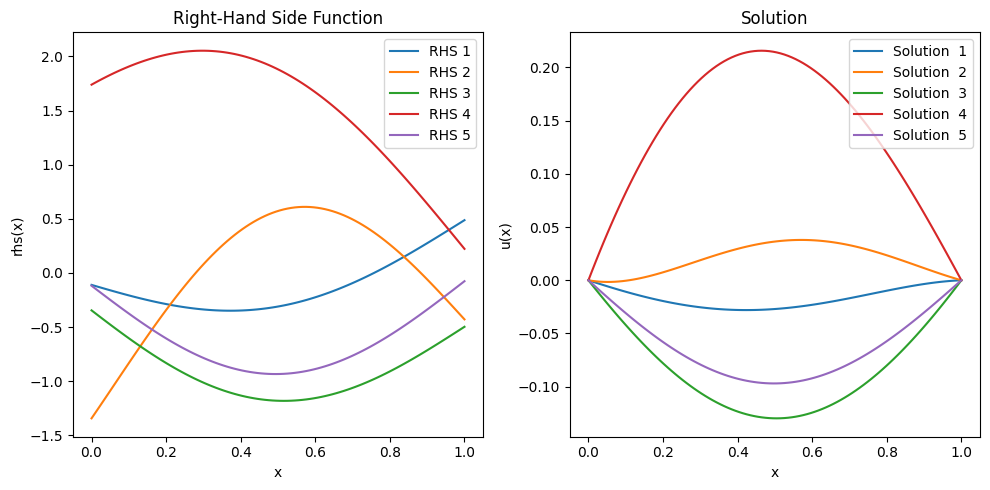

In [ ]:
plot_data(x, rhs, solutions, num_samples_to_plot=5)

In [ ]:
# Initialize the model
model = DeepONet(branch_input_dim=num_collocation_points, trunk_input_dim=1, hidden_dim=50).to(device)


In [ ]:
# train the model
train_deeponet(model, x, rhs, solutions, num_epochs=5000, learning_rate=1e-4)

Epoch [100/5000], Loss: 5.083624274e-05
Epoch [200/5000], Loss: 2.347410555e-05
Epoch [300/5000], Loss: 1.566194624e-05
Epoch [400/5000], Loss: 1.147971216e-05
Epoch [500/5000], Loss: 9.071485692e-06
Epoch [600/5000], Loss: 7.572677532e-06
Epoch [700/5000], Loss: 6.537878562e-06
Epoch [800/5000], Loss: 5.758885436e-06
Epoch [900/5000], Loss: 5.137988410e-06
Epoch [1000/5000], Loss: 4.624473149e-06
Epoch [1100/5000], Loss: 4.188632374e-06
Epoch [1200/5000], Loss: 3.811236866e-06
Epoch [1300/5000], Loss: 3.478929784e-06
Epoch [1400/5000], Loss: 3.181954753e-06
Epoch [1500/5000], Loss: 2.912972832e-06
Epoch [1600/5000], Loss: 2.666334694e-06
Epoch [1700/5000], Loss: 2.437664989e-06
Epoch [1800/5000], Loss: 2.223607680e-06
Epoch [1900/5000], Loss: 2.021587761e-06
Epoch [2000/5000], Loss: 1.829691087e-06
Epoch [2100/5000], Loss: 1.646589453e-06
Epoch [2200/5000], Loss: 1.471498081e-06
Epoch [2300/5000], Loss: 1.304105240e-06
Epoch [2400/5000], Loss: 1.144600105e-06
Epoch [2500/5000], Loss: 

In [ ]:
# Evaluate the model
predicted_solutions = evaluate_deeponet(model, x, rhs)
predicted_solutions.shape


torch.Size([50, 100])

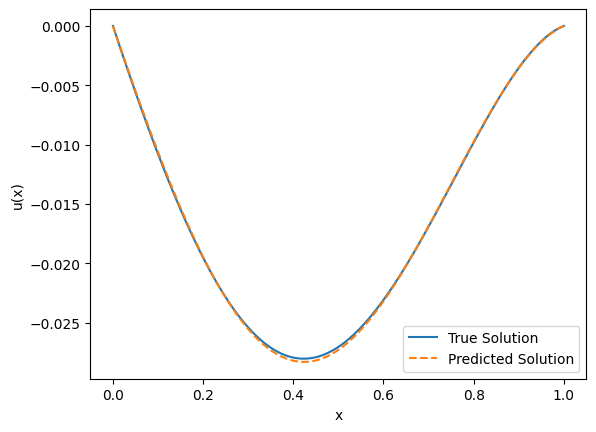

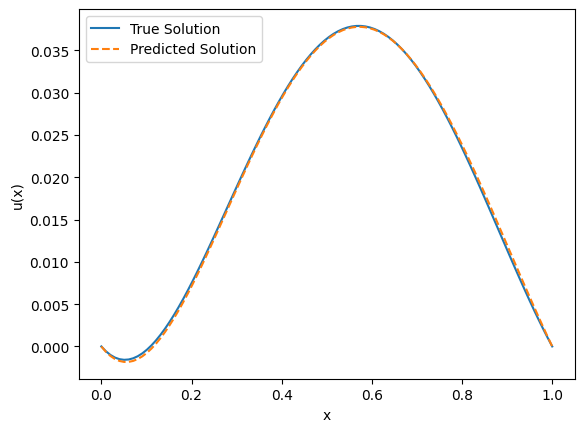

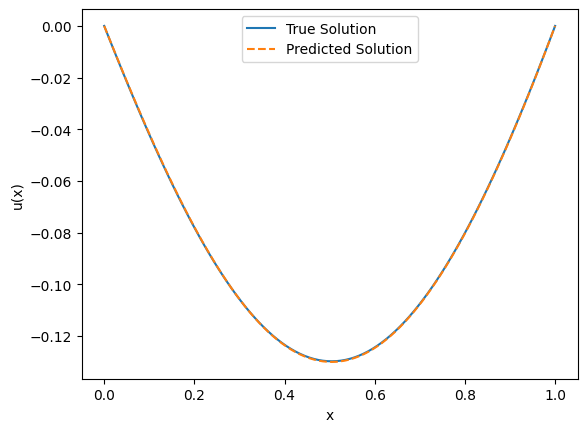

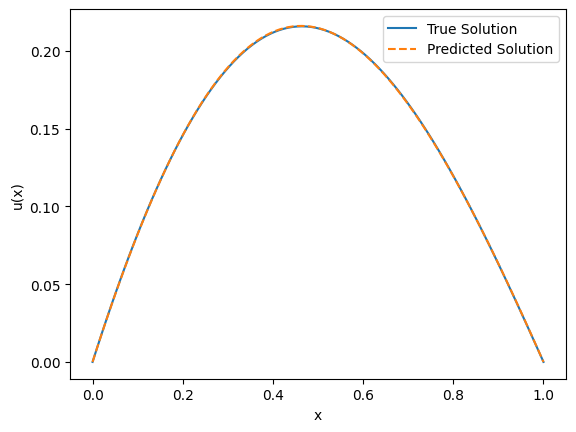

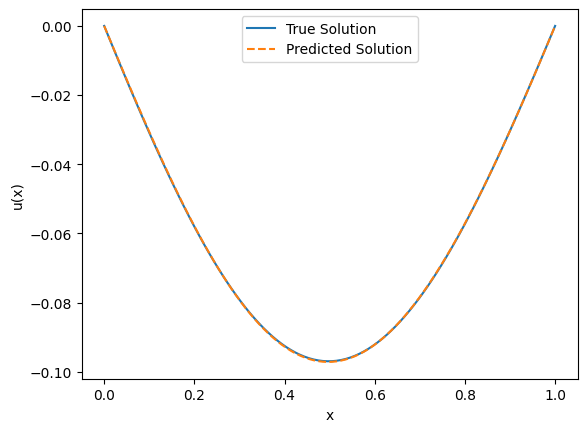

In [ ]:
# Plot results
plot_results(x, solutions, predicted_solutions)